## Level 2: Unit sales of all products, aggregated for all stores/states

In [1]:
import os
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt

from tsforest.trend import compute_trend_models
from tsforest.forecaster import LightGBMForecaster

# local modules
import sys
sys.path.append("../lib/")
from utils import compute_scaling, reduce_mem_usage
from evaluation import _WRMSSEEvaluator

SEEDS = [2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71]

/home/turing/miniconda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



***

In [2]:
def make_valid_periods(end_date, valid_length, n_folds):
    right_date = pd.to_datetime(end_date)
    valid_periods = list()
    
    for i in range(n_folds):
        left_date = right_date - pd.DateOffset(days=valid_length-1)
        valid_periods.append((left_date, right_date))
        right_date = left_date - pd.DateOffset(days=1)
    
    return valid_periods[::-1]

***

In [3]:
data = (pd.read_parquet("../input/train_dataframe.parquet")
        .groupby(["state_id","ds"])
        .agg({"q":"sum",
              "event_name_1":lambda x: int(x.unique()),
              "lw_type":lambda x: int(x.unique()),
              "lw_day":lambda x: int(x.unique()),
              "prev_lw":lambda x: int(x.unique()),
              "post_lw":lambda x: int(x.unique()), 
              "prev_christmas":lambda x: int(x.unique()),
              "post_christmas":lambda x: int(x.unique()),
              "prev_thanksgiving":lambda x: int(x.unique()),
             })
        .reset_index()
       )

data["q"] = data.q.astype(int)
data.rename({"q":"y"}, axis=1, inplace=True)
data.sort_values(["state_id","ds"], inplace=True)
data.reset_index(drop=True, inplace=True)

In [4]:
weights_level2 = pd.read_parquet("../input/weights_level2.parquet")
weights_level2.head()

,state_id,weight
0,1,0.442371
1,2,0.269297
2,3,0.288332


In [5]:
scaling_input = pd.read_parquet("../input/scaling_input.parquet")
scales = compute_scaling(scaling_input, agg_columns=["state_id"]).rename({"q":"s"}, axis=1)
scales.head()

,state_id,s
0,1,2709.476919
1,2,1827.443035
2,3,1940.451981


In [6]:
# outlier removal
remove_idx = data.query("ds.dt.month == 12 & ds.dt.day == 25").index
data.drop(remove_idx, axis=0, inplace=True)

***

In [5]:
weights = (weights_level2
    .merge(scales, how="inner", on=["state_id"])
    .assign(weight = lambda x: x.weight/x.s)
    .assign(weight = lambda x: x.weight/x.weight.median())
    .drop(["s"], axis=1)
)
weights.head()

,state_id,weight
0,1,1.098782
1,2,0.991738
2,3,1.000000


In [ ]:
data = pd.merge(data, weights, how="left", on=["state_id"])
data.head()

***
### time series visualization

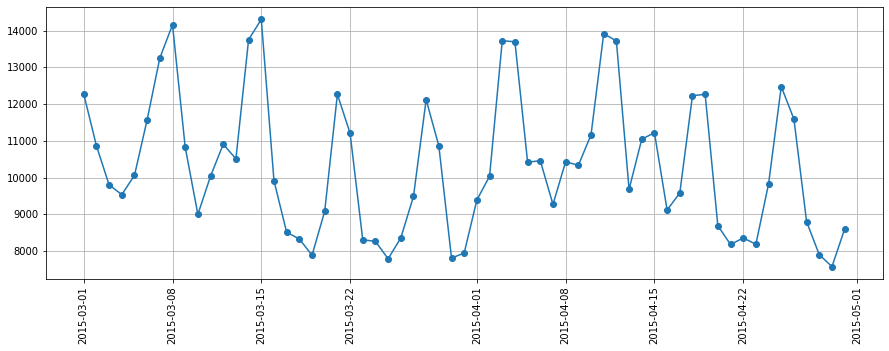

In [7]:
state_id = 3
start_date = '2015-03-01'
end_date = '2015-04-30'

df = data.query("state_id == @state_id & @start_date <= ds <= @end_date")

plt.figure(figsize=(15,5))
plt.plot_date(df.ds, df.y, "o-")
plt.xticks(rotation=90)
plt.grid()
plt.show()

***

In [8]:
##valid_periods = [(pd.to_datetime("2015-04-25"), pd.to_datetime("2015-05-22")),
#                 (pd.to_datetime("2015-05-23"), pd.to_datetime("2015-06-19")),
#                 (pd.to_datetime("2016-02-27"), pd.to_datetime("2016-03-26")),
#                 (pd.to_datetime("2016-03-27"), pd.to_datetime("2016-04-24")),
#                ]

# periods used for validation
valid_periods = make_valid_periods("2016-04-24", valid_length=28, n_folds=13) 
valid_periods

[(Timestamp('2015-04-27 00:00:00'), Timestamp('2015-05-24 00:00:00')),
 (Timestamp('2015-05-25 00:00:00'), Timestamp('2015-06-21 00:00:00')),
 (Timestamp('2015-06-22 00:00:00'), Timestamp('2015-07-19 00:00:00')),
 (Timestamp('2015-07-20 00:00:00'), Timestamp('2015-08-16 00:00:00')),
 (Timestamp('2015-08-17 00:00:00'), Timestamp('2015-09-13 00:00:00')),
 (Timestamp('2015-09-14 00:00:00'), Timestamp('2015-10-11 00:00:00')),
 (Timestamp('2015-10-12 00:00:00'), Timestamp('2015-11-08 00:00:00')),
 (Timestamp('2015-11-09 00:00:00'), Timestamp('2015-12-06 00:00:00')),
 (Timestamp('2015-12-07 00:00:00'), Timestamp('2016-01-03 00:00:00')),
 (Timestamp('2016-01-04 00:00:00'), Timestamp('2016-01-31 00:00:00')),
 (Timestamp('2016-02-01 00:00:00'), Timestamp('2016-02-28 00:00:00')),
 (Timestamp('2016-02-29 00:00:00'), Timestamp('2016-03-27 00:00:00')),
 (Timestamp('2016-03-28 00:00:00'), Timestamp('2016-04-24 00:00:00'))]

***
### training validation models

In [9]:
model_params = {
    'objective': 'l2', 
    'metric': 'None', 
    'num_iterations': 100000, 
    'early_stopping_rounds': 300, 
    'bagging_freq': 1, 
    'num_threads': 10, 
    'learning_rate': 0.2893587542945107, 
    'num_leaves': 12, 
    'max_bin': 97, 
    'feature_fraction': 0.9, 
    'bagging_fraction': 0.8, 
    'min_data_in_leaf': 11, 
    'min_gain_to_split': 100, 
    'lambda_l2': 5.781131218800134, 
    'seed': 71}

time_features = [
    "year",
    "month",
    "year_week",
    "year_day",
    "week_day",
    "month_progress",
    #"week_day_cos",
    #"week_day_sin",
    "year_day_cos",
    "year_day_sin",
    "year_week_cos",
    "year_week_sin",
    #"month_cos",
    #"month_sin"
]

model_kwargs = {
    "model_params":model_params,
    "time_features":time_features,
    "categorical_features":{
        "state_id":"default",
        "event_name_1":"default"},
    "ts_uid_columns":["state_id"],
    
}

In [79]:
# 4+ years of history
train_history = 1800

In [11]:
models = list()
errors = list()
best_iterations = list()

for i,valid_period in enumerate(valid_periods):
    print(f" {i+1}/{len(valid_periods)} ".center(100, "#"))
    print(f" Validation period: {valid_period} ".center(100, "#"))
    print("#"*100)
    
    valid_start = valid_period[0]
    valid_end = valid_period[1]
    
    train_start = valid_start - pd.DateOffset(days=train_history)
        
    _train_data = data.query("@train_start <= ds <= @valid_end").reset_index(drop=True)
    _valid_index = _train_data.query("@valid_start <= ds <= @valid_end").index

    _fcaster = LightGBMForecaster(**model_kwargs)
    _fcaster.prepare_features(train_data=_train_data, valid_index=_valid_index);

    _fcaster.train_features = reduce_mem_usage(_fcaster.train_features)
    _fcaster.valid_features = reduce_mem_usage(_fcaster.valid_features)
    
    evaluator = _WRMSSEEvaluator(_fcaster.valid_features.loc[:, ["ds"]+_fcaster.ts_uid_columns+["y"]], 
                                weights_level2, 
                                scales,
                                ts_uid_columns=_fcaster.ts_uid_columns)
    _fcaster.fit(fit_kwargs={"verbose_eval":25, "feval":evaluator.evaluate})

    
    models.append(_fcaster)
    errors.append(_fcaster.model.model.best_score["valid_0"]["wrmsse"])
    best_iterations.append(_fcaster.best_iteration)

############################################### 1/13 ###############################################
##### Validation period: (Timestamp('2015-04-27 00:00:00'), Timestamp('2015-05-24 00:00:00')) ######
####################################################################################################
Training until validation scores don't improve for 250 rounds
[25]	valid_0's wrmsse: 0.412552
[50]	valid_0's wrmsse: 0.333961
[75]	valid_0's wrmsse: 0.301694
[100]	valid_0's wrmsse: 0.293762
[125]	valid_0's wrmsse: 0.282212
[150]	valid_0's wrmsse: 0.276586
[175]	valid_0's wrmsse: 0.274416
[200]	valid_0's wrmsse: 0.269927
[225]	valid_0's wrmsse: 0.267358
[250]	valid_0's wrmsse: 0.267962
[275]	valid_0's wrmsse: 0.264734
[300]	valid_0's wrmsse: 0.264536
[325]	valid_0's wrmsse: 0.267317
[350]	valid_0's wrmsse: 0.266413
[375]	valid_0's wrmsse: 0.267099
[400]	valid_0's wrmsse: 0.265399
[425]	valid_0's wrmsse: 0.264947
[450]	valid_0's wrmsse: 0.262417
[475]	valid_0's wrmsse: 0.263343
[500]	valid

In [13]:
models = list()
errors = list()
best_iterations = list()

for i,valid_period in enumerate(valid_periods):
    print(f" {i+1}/{len(valid_periods)} ".center(100, "#"))
    print(f" Validation period: {valid_period} ".center(100, "#"))
    print("#"*100)
    
    valid_start = valid_period[0]
    valid_end = valid_period[1]
    
    train_start = valid_start - pd.DateOffset(days=train_history)
        
    _train_data = data.query("@train_start <= ds <= @valid_end").reset_index(drop=True)
    _valid_index = _train_data.query("@valid_start <= ds <= @valid_end").index

    _fcaster = LightGBMForecaster(**model_kwargs)
    _fcaster.prepare_features(train_data=_train_data, valid_index=_valid_index);

    _fcaster.train_features = reduce_mem_usage(_fcaster.train_features)
    _fcaster.valid_features = reduce_mem_usage(_fcaster.valid_features)
    
    evaluator = _WRMSSEEvaluator(_fcaster.valid_features.loc[:, ["ds"]+_fcaster.ts_uid_columns+["y"]], 
                                weights_level2, 
                                scales,
                                ts_uid_columns=_fcaster.ts_uid_columns)
    _fcaster.fit(fit_kwargs={"verbose_eval":25, "feval":evaluator.evaluate})

    
    models.append(_fcaster)
    errors.append(_fcaster.model.model.best_score["valid_0"]["wrmsse"])
    best_iterations.append(_fcaster.best_iteration)

############################################### 1/13 ###############################################
##### Validation period: (Timestamp('2015-04-27 00:00:00'), Timestamp('2015-05-24 00:00:00')) ######
####################################################################################################
Training until validation scores don't improve for 250 rounds
[25]	valid_0's wrmsse: 0.412932
[50]	valid_0's wrmsse: 0.360731
[75]	valid_0's wrmsse: 0.338011
[100]	valid_0's wrmsse: 0.332526
[125]	valid_0's wrmsse: 0.322089
[150]	valid_0's wrmsse: 0.315244
[175]	valid_0's wrmsse: 0.307113
[200]	valid_0's wrmsse: 0.302076
[225]	valid_0's wrmsse: 0.298601
[250]	valid_0's wrmsse: 0.293066
[275]	valid_0's wrmsse: 0.288581
[300]	valid_0's wrmsse: 0.287162
[325]	valid_0's wrmsse: 0.286011
[350]	valid_0's wrmsse: 0.28308
[375]	valid_0's wrmsse: 0.282822
[400]	valid_0's wrmsse: 0.284732
[425]	valid_0's wrmsse: 0.282958
[450]	valid_0's wrmsse: 0.281036
[475]	valid_0's wrmsse: 0.280803
[500]	valid_

In [14]:
np.mean(errors)

0.42587519076935665

***
### training final model

In [11]:
#model_kwargs["model_params"]["num_iterations"] = int(np.median(best_iterations))
model_kwargs["model_params"]["num_iterations"] = 435
model_kwargs["model_params"]

{'objective': 'l2',
 'metric': 'None',
 'num_iterations': 435,
 'early_stopping_rounds': 300,
 'bagging_freq': 1,
 'num_threads': 10,
 'learning_rate': 0.2893587542945107,
 'num_leaves': 12,
 'max_bin': 97,
 'feature_fraction': 0.9,
 'bagging_fraction': 0.8,
 'min_data_in_leaf': 11,
 'min_gain_to_split': 100,
 'lambda_l2': 5.781131218800134,
 'seed': 71}

In [12]:
train_data = data.copy(deep=True)
all_models = list()

for seed in SEEDS:
    model_kwargs["model_params"]["seed"] = seed
    model_kwargs["trend_models"] = compute_trend_models(train_data, ts_uid_columns=["state_id"])
    fcaster = LightGBMForecaster(**model_kwargs)
    fcaster.prepare_features(train_data=train_data);
    fcaster.fit()
    all_models.append(fcaster)

100%|██████████| 3/3 [00:00<00:00, 5171.77it/s]


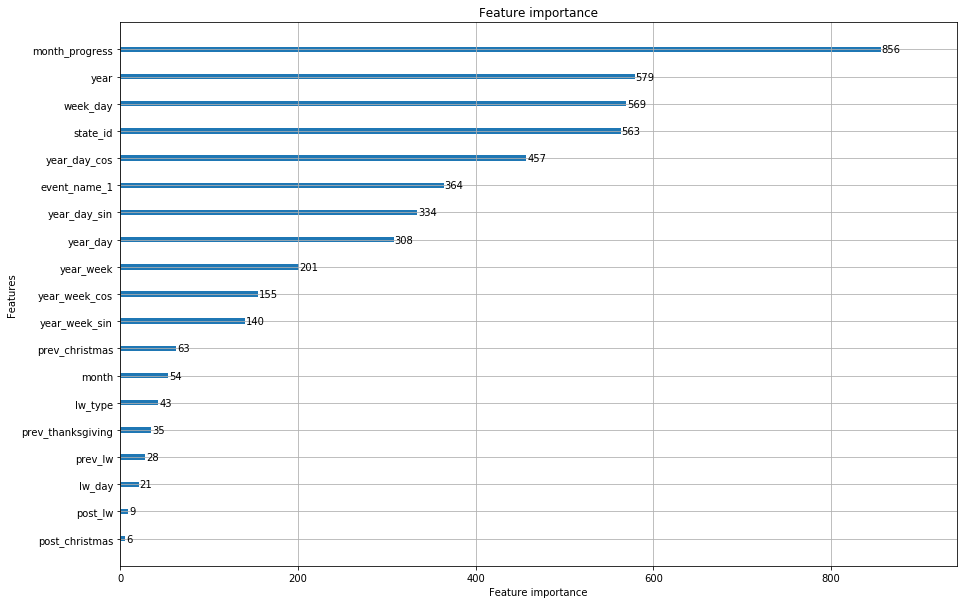

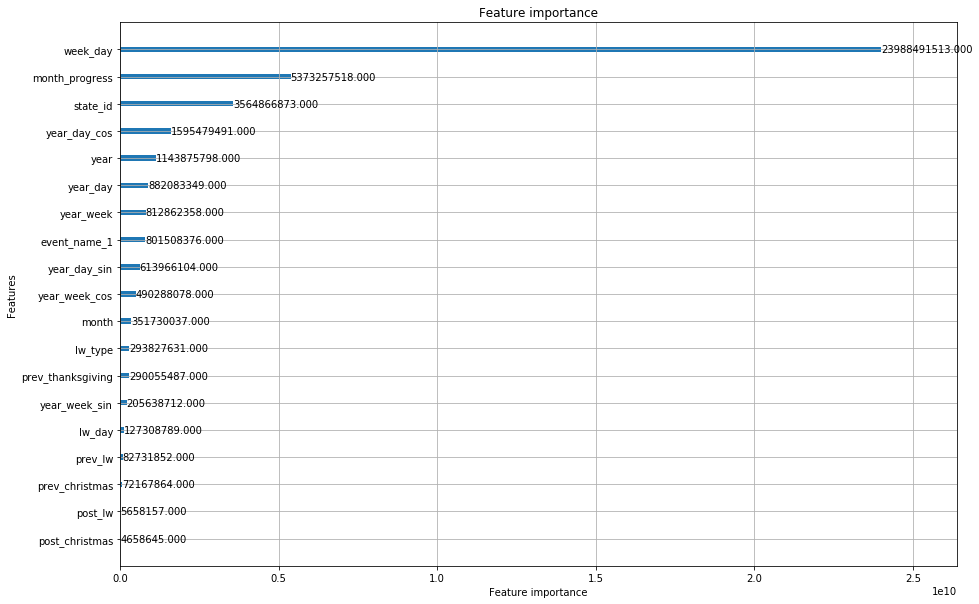

In [13]:
fcaster = all_models[7]
lgb.plot_importance(fcaster.model.model, importance_type="split", figsize=(15,10));
lgb.plot_importance(fcaster.model.model, importance_type="gain", figsize=(15,10));

***
### estimating residuals

In [63]:
%%time
left_date = train_data.ds.max() - pd.DateOffset(years=3)

all_predictions = list()
for fcaster in all_models:
    predictions = fcaster.predict(train_data.query("ds >= @left_date").loc[:, data.columns.drop("y")])
    all_predictions.append(predictions)
predictions = all_predictions[0].copy(deep=True)
predictions["y_pred"] = np.mean([_predictions.y_pred for _predictions in all_predictions], axis=0)

CPU times: user 15.5 s, sys: 2.96 s, total: 18.4 s
Wall time: 1.88 s


In [64]:
residuals_raw = (pd.merge(train_data, predictions, how="inner", on=["state_id","ds"])
                 .assign(residual = lambda x: x.y - x.y_pred)
                 .loc[:, ["ds","state_id","y","y_pred","residual"]])

In [65]:
#%%time
#n_repetitions = 20
#sample_size = 0.66
#all_residual_deviance = list()
#for i in range(n_repetitions):
#    _residual_deviance = (residuals_raw.groupby(["state_id"]).apply(lambda x: x.sample(frac=sample_size))
#                          .reset_index(drop=True)
#                          .groupby(["state_id"])["residual"].std()
#                          .reset_index())
#    all_residual_deviance.append(_residual_deviance)

In [66]:
#residual_deviance = all_residual_deviance[0].copy(deep=True)
#residual_deviance["residual"] = np.mean([_residual_deviance.residual.values for _residual_deviance in all_residual_deviance], axis=0)
#residual_deviance

In [67]:
def compute_residual_deviance(df):
    q01 = df.residual.quantile(0.01)
    q99 = df.residual.quantile(0.99)
    df["residual"] = df.query("@q01 <= residual <= @q99").residual.std()
    return df.loc[:, ["state_id","residual"]].drop_duplicates(subset=["state_id"])

residual_deviance = (residuals_raw
                     .groupby(["state_id"]).apply(compute_residual_deviance)
                     .reset_index(drop=True))
residual_deviance

,state_id,residual
0,1,412.732701
1,2,362.774696
2,3,374.457697


In [68]:
residual_deviance.to_parquet("../output/residuals_level2-v4.parquet", index=False)

In [69]:
residual_deviance

,state_id,residual
0,1,412.732701
1,2,362.774696
2,3,374.457697


In [77]:
412.732701/362.774696

1.1377108314081532

In [71]:
scales

,state_id,s
0,1,2709.476919
1,2,1827.443035
2,3,1940.451981


In [72]:
nscales.s

0    52.052636
1    42.748603
2    44.050562
Name: s, dtype: float64

In [76]:
14682.5/9649.5

1.5215814290895902

In [78]:
np.log(data.groupby(["state_id"])["y"].median())

state_id
1    9.594412
2    9.174661
3    9.141687
Name: y, dtype: float64

***
### prediction

In [18]:
valid_dataframe = (pd.read_parquet("../input/valid_dataframe.parquet")
                   .loc[:, train_data.columns.drop("y")]
                   .drop_duplicates()
                   #.merge(weights, how="left", on="state_id")
                  )
eval_dataframe = (pd.read_parquet("../input/eval_dataframe.parquet")
                  .loc[:, train_data.columns.drop("y")]
                  .drop_duplicates()
                  #.merge(weights, how="left", on="state_id")
                 )

In [19]:
all_forecasts = list()
for fcaster in all_models:
    _forecast = fcaster.predict(pd.concat([valid_dataframe, eval_dataframe], ignore_index=True))
    all_forecasts.append(_forecast)
    
forecast = all_forecasts[0].copy(deep=True)
forecast["y_pred"] = np.mean([_forecast.y_pred for _forecast in all_forecasts], axis=0)

In [20]:
forecast.to_csv("../output/forecast_level2-v2.csv", index=False)

***